Dataset Shape: (48842, 15)
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-pe

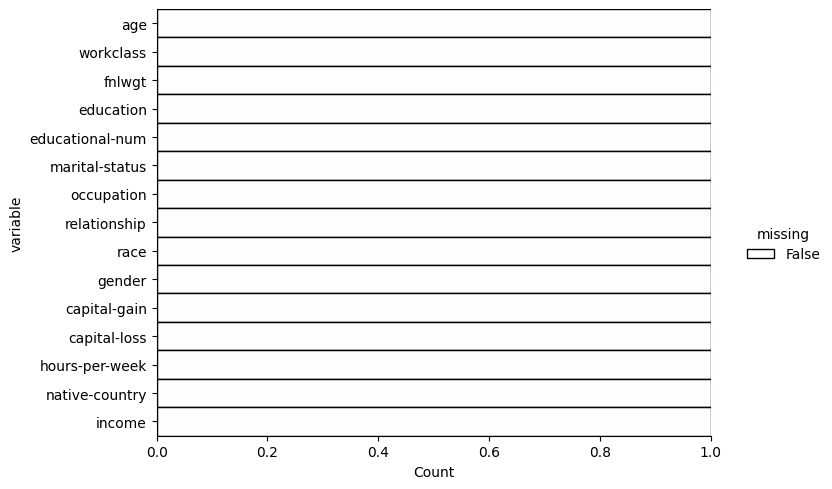

[LightGBM] [Info] Number of positive: 9335, number of negative: 29738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238912 -> initscore=-1.158655
[LightGBM] [Info] Start training from score -1.158655
✅ Accuracy for the model: 0.8700


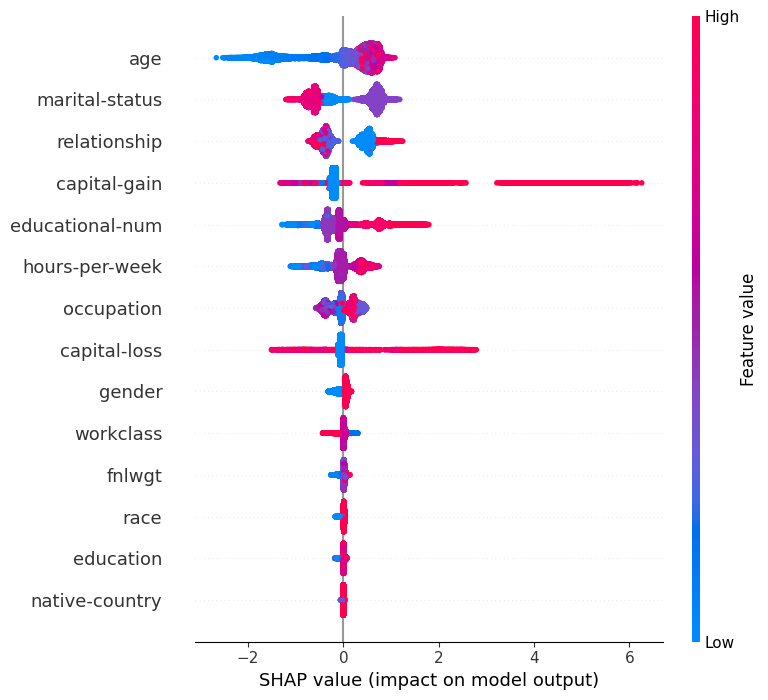

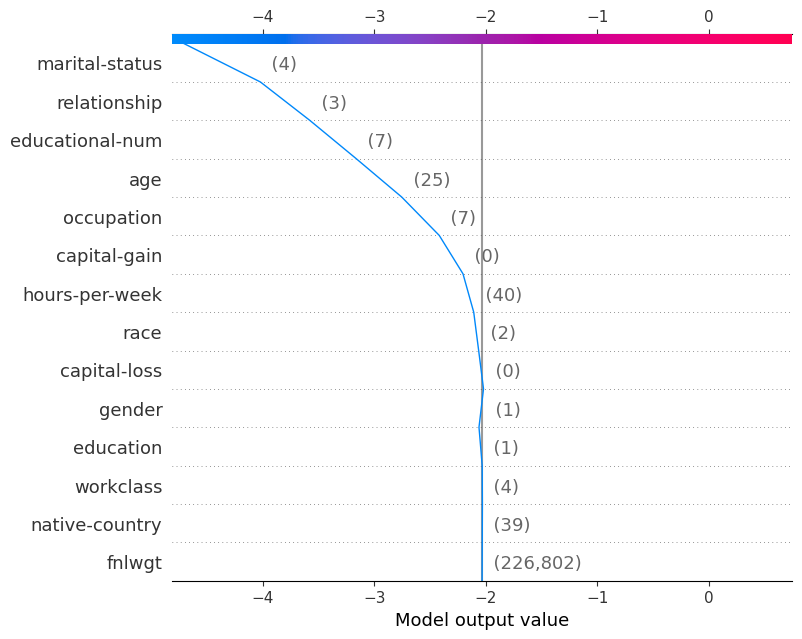

Feature Dependence plot for: age


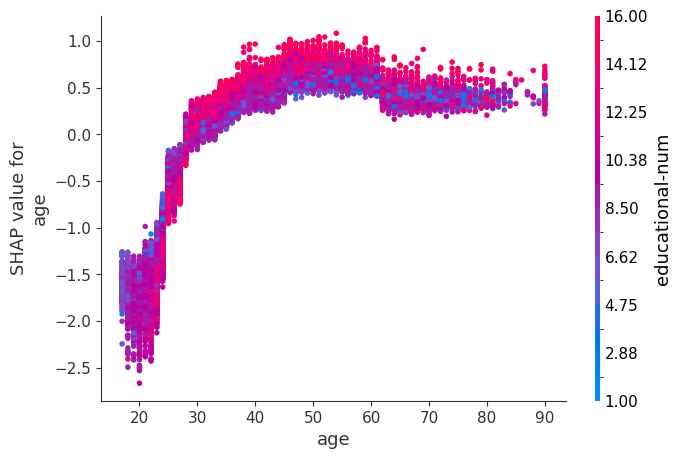

Feature Dependence plot for: education


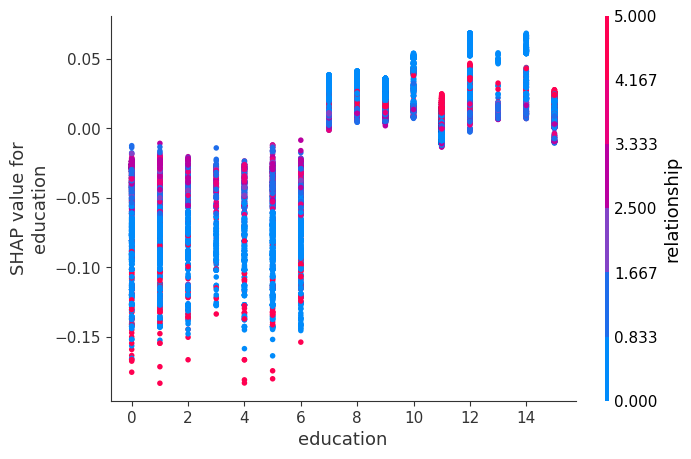

Feature Dependence plot for: occupation


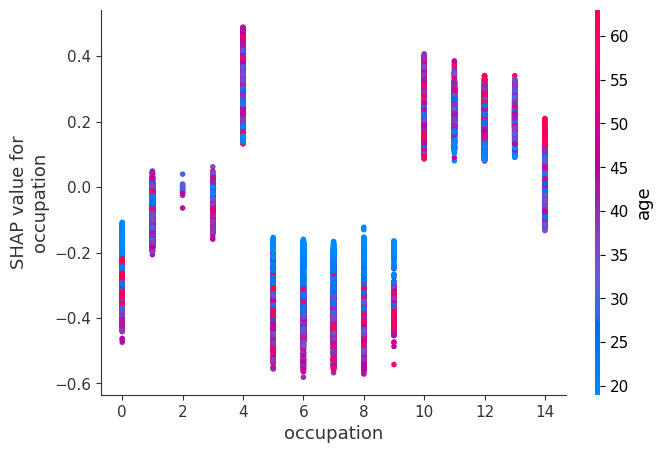

Feature Dependence plot for: hours-per-week


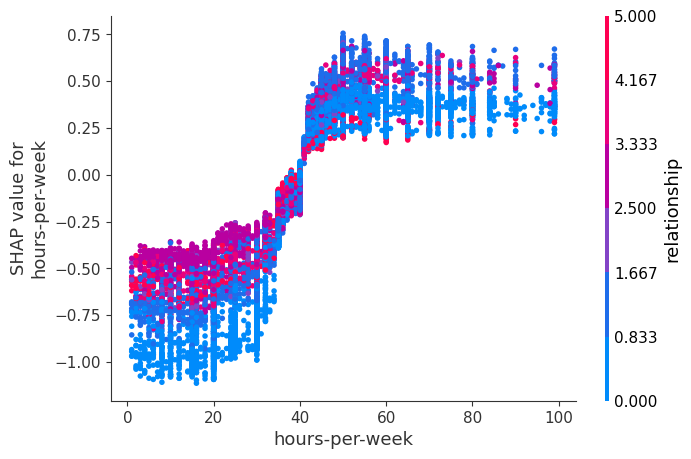

Feature Dependence plot for: capital-gain


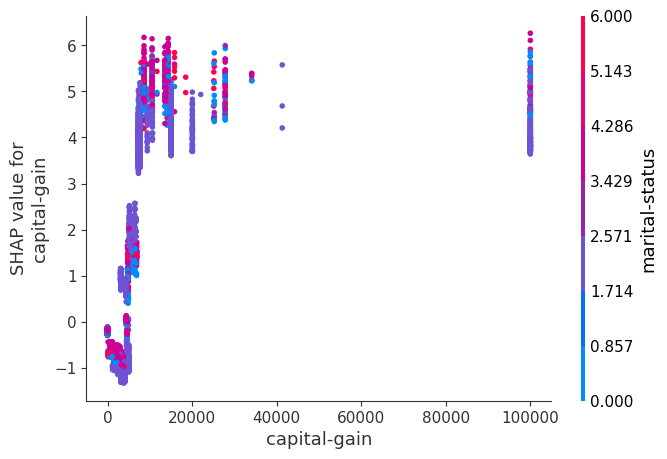

In [9]:
# ✅ Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# ✅ Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# ✅ Load Dataset
file_path = "/content/adult.csv"  # Ensure correct file path
data = pd.read_csv(file_path)

# ✅ Display dataset info
print("Dataset Shape:", data.shape)
print(data.head())

# ✅ Identify numerical and categorical features
num_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = data.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features:", num_features)
print("Categorical Features:", cat_features)

# ✅ Check for missing values (Visualization)
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.5,
    palette='seismic'
)
plt.show()

# ✅ Fill missing categorical values with 'Unknown'
data.fillna('Unknown', inplace=True)

# ✅ Ensure 'income' column exists
if 'income' not in data.columns:
    raise ValueError("Column 'income' not found in dataset. Check column names.")

# ✅ Label Encoding categorical features
le = LabelEncoder()
for feat in cat_features:
    data[feat] = le.fit_transform(data[feat])

# ✅ Split dataset into features and labels
features = data.drop(columns=['income'])  # Assuming 'income' is the target variable
labels = le.fit_transform(data['income'])  # Convert labels to binary

# ✅ Train-test split (80:20)
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=123)

# ✅ Convert to LightGBM dataset format
data_train = lgb.Dataset(x_train, label=y_train)
data_test = lgb.Dataset(x_test, label=y_test)

# ✅ LGBM Model parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'seed': 123
}

# ✅ Train the LightGBM model (Fix: Removed 'verbose_eval')
model = lgb.train(params, data_train, num_boost_round=100, valid_sets=[data_test])

# ✅ Model evaluation
y_pred = model.predict(x_test)
y_pred = [1 if y > 0.5 else 0 for y in y_pred]
print(f'✅ Accuracy for the model: {accuracy_score(y_test, y_pred):.4f}')

# ✅ SHAP Explainability
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

# ✅ Global explainability - Summary plot
shap.summary_plot(shap_values, features)

# ✅ Decision Plot (Fix: Ensure correct indexing)
if isinstance(explainer.expected_value, list):  # If multi-class case
    expected_val = explainer.expected_value[0]
    shap_val_instance = shap_values[0][0, :]
else:  # If binary case
    expected_val = explainer.expected_value
    shap_val_instance = shap_values[0, :]

shap.decision_plot(expected_val, shap_val_instance, features.iloc[0, :])

# ✅ Feature Dependence plots
important_features = ['age', 'education', 'occupation', 'hours-per-week', 'capital-gain']
for col in important_features:
    print(f"Feature Dependence plot for: {col}")
    shap.dependence_plot(col, shap_values, features, display_features=features)
